# Decision Trees

# Exercises

## 1.
The depth of a well-balanced Decision Tree is about $\log_2(m)$ (rounded up), where $m$ is the number of instances. For one million instances, we have $\log_2(10^6) \approx 20$. In practice the tree will probably be a bit deeper, since they are generally not perfectly well balanced.

## 2.
The Gini impurity of a node is _generally_ lower than its parent's. However, it can be higher as long as this is justified by a decrease in the other child's impurity.

## 3.
Decreasing the maximum depth of a Decision Tree is a form of regularization, decreasing the degree of freedom of the model, which, in turn, makes overfitting the data less likely. Therefore, reducing the maximum depth is a good idea if the model is overfitting.

## 4.
Decision Trees are not sensitive the input's scales, therefore doing so would not prevent the model from underfitting. If the model is regularized, a good approach is to "loose" the regularization parameters in order to obtain a more complex model.

## 5.
Training a Decision Tree takes time in the order of $\mathcal{O}(n \times m \log_2(m))$. If the input size $m$ is multiplied by 10, we would have an increase of $K$ times in the training time, where $K$ is given by:

$$
K = \frac{n \times 10m \log_2(10m)}{n \times m \log_2(m)} = \frac{10 \log_2(10m)}{\log_2(m)} \approx 11.7
$$

## 6.
In this case, setting `presort=True` would actually considerably slow down the training set, given its size. This setting would only speed up training if the dataset is smaller than a few hundred instances.

## 7.

Let's start by loading the data, splitting it into the train and test sets, and visualize the training set:

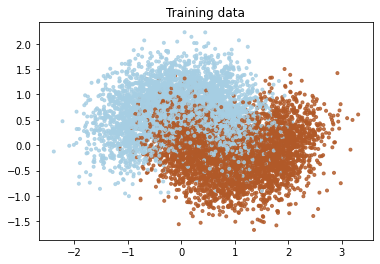

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='.', alpha=0.8, cmap=plt.cm.Paired)
plt.title('Training data');

We will establish a baseline using the `DecisionTreeClassifier` with the default parameters:

In [2]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier().fit(X_train, y_train)
dt_clf.score(X_train, y_train)

1.0

Seems like the model is badly overfitting the training data! This classification task is not trivial (as we can see in the previous figure), so a perfect score is, at least, very suspicious! We can confirm this by evaluating the model using cross-validation:


In [3]:
from sklearn.model_selection import cross_val_score

cross_val_score(dt_clf, X_train, y_train, cv=5)

array([0.784375, 0.804375, 0.814375, 0.784375, 0.810625])

As we can see, the model does not generalize very well! We already know that we need to regularize the model, so let's perform a grid search to find a promising set of hyperparameters:

In [4]:
from sklearn.model_selection import GridSearchCV

params = {'criterion': ['gini', 'entropy'], 'max_depth': list(range(2, 10)), 'min_samples_leaf': [1, 5, 10, 20]}

grid_search = GridSearchCV(dt_clf, params, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=20)

Now we've got ourselves (probably) a much more reasonable model. We can evaluate its performance by measuring the accuracy on both the train and the test set:

In [5]:
grid_search.best_estimator_.score(X_train, y_train)

0.866625

In [6]:
grid_search.best_estimator_.score(X_test, y_test)

0.8695

## 8.

We start by splitting the training data in 1000 subsets:

In [7]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)

We now train one Decision Tree in each subset. Each of these models is evaluated on the test set, and we print their mean accuracy:

In [8]:
from sklearn.base import clone
import numpy as np

forest = [clone(grid_search.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for idx, (train_idx, test_idx) in enumerate(rs.split(X_train)):
    forest[idx].fit(X_train[train_idx], y_train[train_idx])
    accuracy_scores.append(forest[idx].score(X_test, y_test))
    
np.mean(accuracy_scores)

0.7733005

Now, for each classifier trained, we will generate predictions on the entire test set:

In [9]:
y_pred = np.zeros((n_trees, len(X_test)), dtype=np.uint8)

for idx, tree in enumerate(forest):
    y_pred[idx] = tree.predict(X_test)

With this, we can generate final predictions by using the most frequent prediction:

In [10]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(y_pred, axis=0)

Finally, we assess the accuracy of the final predictions

In [11]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred_majority_votes.reshape(-1))

0.7945

And there it is: our very own Random Forest classifier!